In [18]:
# General libraries
import pandas as pd
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import accuracy_score 

# The library we have created
import Utilities as ut

%matplotlib notebook

## Data preparation

In [2]:
# Open the dataset
df = pd.read_csv("dataset/Other/dataset.csv", index_col = [0])

# Drop useless columns
df = df.drop(["MW","home_team_name", "away_team_name"], 1)

In [3]:
# Create an empty dataframe
odd_data = pd.DataFrame(None)

# Aggregate all the files in a single one
dataset_position_PL = "dataset/Premier League/"

# Identify all the datatests within the directory
file_list_PL = os.listdir(dataset_position_PL) 

for element in file_list_PL:
    data = ut.open_csv(element,dataset_position_PL)
    data = ut.match_week(data)
    odd_data = odd_data.append(data, ignore_index = True)

# Sorting the dataframe
odd_data = odd_data.sort_values(by = ['timestamp'])

# Keep only some columns
col_to_keep = ['MW','home_team_name', 'away_team_name','odds_ft_home_team_win','odds_ft_draw', 'odds_ft_away_team_win']
odd_data = odd_data[col_to_keep]

# Drop the rows of the first 5 weeks, in order to have a full dataset
odd_data = odd_data[odd_data.MW > 5].reset_index(drop = True)

# Keep only the bookmaker's odds for the last year 
odd_data = odd_data[1320:]

# Using the first 4 years as training
test_data = df[1320:]

# Using the last year as test dataset
train_data = df[:1320]

## Preparing  X

In [4]:
# Dropping the "Result" column
X_test = test_data.drop('Result',1)
X_train = train_data.drop('Result',1)

## Preparing Y

In [5]:
# Keeping only the "Result" column
y_test = test_data.Result
y_train = train_data.Result

## Prediction

In [6]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Fit the model
rfc = RandomForestClassifier(random_state = 42, n_estimators = 30)
rfc.fit(X_train, y_train)

# Predict
y_pred_test = rfc.predict(X_test)

# Predict the probabilities of each class
y_pred_probability = rfc.predict_proba(X_test)

# Compute Accuracy
test_acc = accuracy_score(y_test, y_pred_test)

# Adding to the dataframe the predicted output
test_data['Prediction'] = y_pred_test
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.5636363636363636


In [8]:
# Creating a new dataframe with the probabilities to predict a result
df_prob = pd.DataFrame({'home_prob': [row[2] for row in y_pred_probability],
                        'draw_prob': [row[1] for row in y_pred_probability],
                        'away_prob': [row[0] for row in y_pred_probability]})

# Keeping only certains columns
test_data = test_data[['Result','Prediction']]

# Merging together the two datasets
dataset = pd.concat([test_data.reset_index(drop = True) ,
                    odd_data.reset_index(drop = True), df_prob],1)
dataset.head(3)

,Result,Prediction,MW,home_team_name,away_team_name,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,home_prob,draw_prob,away_prob
0,D,A,6,Fulham,Watford,2.85,3.45,2.55,0.300000,0.333333,0.366667
1,H,H,6,Leicester City,Huddersfield Town,1.71,3.65,5.70,0.533333,0.200000,0.266667
2,D,D,6,Crystal Palace,Newcastle United,2.05,3.40,4.05,0.300000,0.366667,0.333333


In [9]:
# Adding the winning odd

Verification = []

for res, pred, hw, d, aw  in zip (dataset['Result'], dataset['Prediction'],
                                  dataset['odds_ft_home_team_win'],
                                  dataset['odds_ft_draw'],
                                  dataset['odds_ft_away_team_win']):
    if res == pred:
        if pred == 'A':
            # Adding the odd for Away 
            Verification.append(aw)
        elif pred == 'D':
            # Adding the odd for Draw
            Verification.append(d)
        else:
            # Adding the odd for Home
            Verification.append(hw)  
    else:
        # Adding 0.0 if the prediction is wrong
        Verification.append(0.0)

# Adding the list to the dataframe
dataset['Verification'] = Verification 
dataset.head(3)

,Result,Prediction,MW,home_team_name,away_team_name,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,home_prob,draw_prob,away_prob,Verification
0,D,A,6,Fulham,Watford,2.85,3.45,2.55,0.300000,0.333333,0.366667,0.00
1,H,H,6,Leicester City,Huddersfield Town,1.71,3.65,5.70,0.533333,0.200000,0.266667,1.71
2,D,D,6,Crystal Palace,Newcastle United,2.05,3.40,4.05,0.300000,0.366667,0.333333,3.40


## Betting strategy

For each match week, we have the predicted probabilities for each game: the home win probability, the draw probability and the away win probability. On this base we apply our betting strategy.
Our betting strategy is composed of 5 steps:
<ol>
<li><b>Select the 5 biggest probabilities</b> among all the games of a specific match week.</li>
<li><b>Calculate the Caution Betting Index (CBI)</b> for each probability <u>(The index has been invented by us)</u></li>
    
<li> Choose the <b>3 probabilities with the lowest CBI </b> </li>
<li> <b>Multiply the 3 odds</b> (Only if all of the 3 predictions were guessed)</li>
<li> <b>Multiply the number obtained</b> in the previous step with the amount of money bet</li>
</ol>

<center><B>Caution Betting Index</B> = $|{(Prob_1.) * 0.5}$ - ${(|Prob_2- Prob_3|)}|$</center><br>

$Prob_1$ --> Highest probability<br>
$Prob_2$ --> One of the two lowest probabilities<br>
$Prob_3$ --> One of the two lowest probabilities

In [10]:
def betting_strategy(df, money):
    
    # Set the quantity of money won
    money_won = 0 
    
    # Store the result of the wallet
    money_won_list = []
    
    # Store the result of the trend
    trend = []
    for end in range (10, len(df), 10):
        start = end - 10 

        # Considering one match week at a time
        matchweek = df[start : end].reset_index(drop = True)
        
        # Get the three highest probability values
        prob_list = list(matchweek['home_prob']) + list(matchweek['draw_prob']) + list(matchweek['away_prob'])
        
        # Store top values
        index, top_value = get_biggest_value(prob_list)
    
        # Get the three highest odds
        index_no_dup, values_no_dup = get_best_3(matchweek, index, top_value)

        # Get the relatives odds
        moltipicator = get_odd(matchweek, index_no_dup)

        # Calculate how much money we have lost/won
        win_loss = (money * moltipicator) - money
        money_won += win_loss
        money_won_list.append(win_loss)
        trend.append(money_won)
        
    
    return money_won_list, money_won, trend

In [11]:
def get_biggest_value(L):
    
    # 5 biggest values
    biggest = []
    
    # Index of 5 biggest values
    index = []
    
    # Sorting the list and getting the five highest values
    sort_L = (sorted(L, reverse = True))[:5]
    
    for i, element in enumerate(L):
        if element in sort_L :
            if len(index) == 5:
                continue
            else:
                # Add the index to the list 
                index.append(i)
                # Add the element to the list 
                biggest.append(element) 
        
    return index, biggest

In [12]:
def get_odd(df, odd_list):
    odds = []

    for index in odd_list:
        
        # Home probability
        if index <= 9:
            
            # Get the odds
            odds.append(df.get_value(index,'Verification'))
            
        # Draw probability
        elif index <= 19 and index > 9 :
            
            # Get the odds
            odds.append(df.get_value(index - 10,'Verification'))

        # Away probability
        else:
            
            # Get the odds
            odds.append(df.get_value(index - 20,'Verification'))

    # Return product of the odds 
    return np.prod(np.array(odds))

In [13]:
def get_best_3 (df, odd_index, odd_list):
    
    # Storing the local index
    index = []
    
    # Storing the differences
    check = []
    
    # Storing the index of the 3 highest probabilities
    best_tree_index = []
    
    # Storing the values of the 3 highest probabilities
    best_tree_values = []
    
    for i, element in enumerate(odd_list):

        # Home win probability
        if odd_index[i] <= 9:
        
            # Get the draw probability
            draw_prop = df.get_value(odd_index[i],'draw_prob')
            # Get the away win probability
            away_prop = df.get_value(odd_index[i],'away_prob')
            # Making the CBI
            cbi = abs(element*0.5 - abs(draw_prop - away_prop))
            check.append(cbi)      

        # Draw probability
        elif odd_index[i] <= 19 and odd_index[i] > 9 :

            # Get the home win probability
            home_prop = df.get_value(odd_index[i]-10,'home_prob')
            # Get the away win probability
            away_prop = df.get_value(odd_index[i]-10,'away_prob')
            # Making the CBI
            cbi = abs(element*0.5 - abs(draw_prop - away_prop))
            check.append(cbi)

        # Away win probability
        else:
            
            # Get the home win probability
            home_prop = df.get_value(odd_index[i]-20,'home_prob')
            # Get the draw probability
            draw_prop = df.get_value(odd_index[i]-20,'draw_prob')
            # Making the CBI
            cbi = abs(element*0.5 - abs(draw_prop - home_prop))
            check.append(cbi)
    
    # Getting the 3 lowest differnces
    lowest = sorted(check)[:3 - len(index)]
    
    # Appending "local" index to the list
    for key, value in dict(sorted(get_duplicate_indexes(check).items())).items():
        for w in value:
            if len(index) == 3:
                break
            else:
                index.append(w)
    

    # Getting the indexes of these 3 probabilities
    for i in index:
        best_tree_index.append(odd_index[i])
        
    # Getting the values of these 3 probabilities
    for i in index:
        best_tree_values.append(odd_list[i])
    
    return best_tree_index, best_tree_values

In [14]:
def get_duplicate_indexes(L):
    # Empty dictionary
    dup_index = {}
    
    # Get index and val in the list
    for i, val in enumerate(L):
        
        # Adding the key 
        if val not in dup_index:
            dup_index[val] = []
            
        # Adding the value
        dup_index[val].append(i)
    return dup_index

### Plot

In [16]:
money_to_bet = 5
wallet_list, money_won, trend = betting_strategy(dataset, money_to_bet)  

<IPython.core.display.Javascript object>


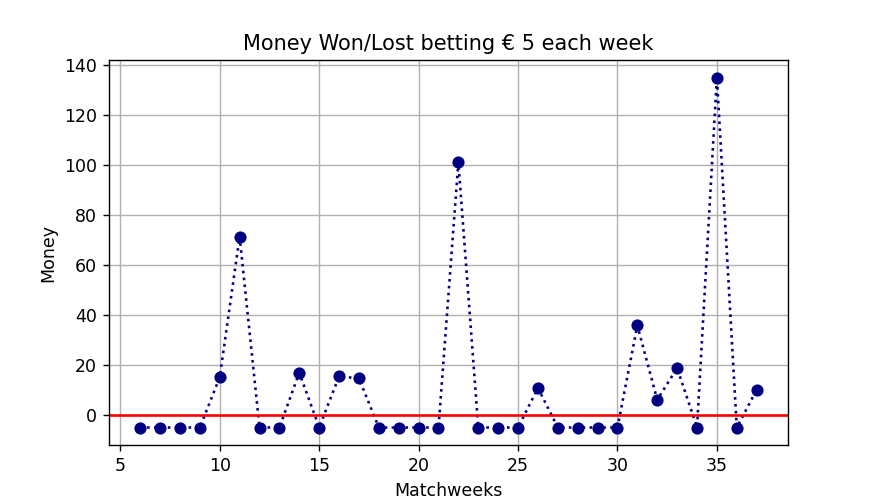

At the end of the season you would win € 351 betting € 165


In [19]:
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(range(6,38), wallet_list, 'o:', label = 'Wallet', color = "navy")
ax.set_title("Money Won/Lost betting € " + str(money_to_bet) + " each week")
ax.set_xlabel("Matchweeks")
ax.set_ylabel("Money")
ax.grid()
# Adding a line to the plot
plt.axhline(0, color = 'r')
print("At the end of the season you would win €" ,
      int(money_won), "betting €", money_to_bet*33 )

<IPython.core.display.Javascript object>


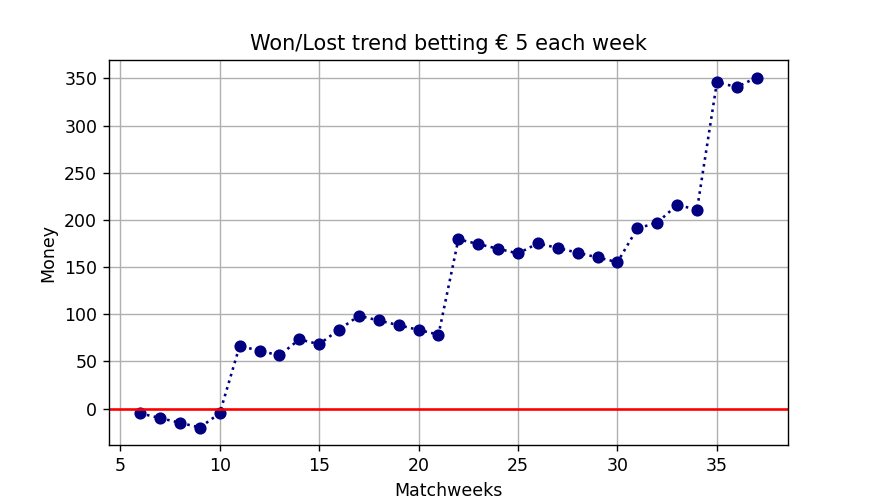

In [20]:
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(range(6,38), trend, 'o:', label = 'Trend', color = "navy")
ax.set_title("Won/Lost trend betting € " + str(money_to_bet) + " each week")
ax.set_xlabel("Matchweeks")
ax.set_ylabel("Money")
ax.grid()
# Adding a line to the plot
plt.axhline(0, color = 'r')